In [1]:
from collections import defaultdict
import numpy as np

class SymmetricQMatrix:
    def __init__(self, default_value=0.0):
        # Q-matrix storing canonical state-action pairs
        self.q_matrix = defaultdict(lambda: defaultdict(lambda: default_value))
        # Precompute symmetries and their inverses
        self.action_symmetries, self.inverse_symmetries = self._generate_action_symmetries_with_inverses()

    def _to_matrix(self, board):
        """
        Convert a linear board to a 3x3 matrix for easier manipulation
        """
        return np.array(board).reshape(3, 3)

    def _to_linear(self, matrix):
        """
        Convert a 3x3 matrix back to a linear board representation.
        """
        return matrix.flatten().tolist()

    def _generate_symmetries(self, board):
        """
        Generate all symmetrical transformations of a board
        """
        matrix = self._to_matrix(board)
        symmetries = [
            matrix,                        # Original
            np.rot90(matrix, 1),           # Rotate 90°
            np.rot90(matrix, 2),           # Rotate 180°
            np.rot90(matrix, 3),           # Rotate 270°
            np.fliplr(matrix),             # Horizontal reflection
            np.flipud(matrix),             # Vertical reflection
            np.transpose(matrix),          # Diagonal reflection (TL-BR)
            np.fliplr(np.transpose(matrix)) # Diagonal reflection (TR-BL)
        ]
        return [self._to_linear(sym) for sym in symmetries]

    def _get_canonical_representation(self, board):
        symmetries = self._generate_symmetries(board)
        return tuple(min(symmetries))

    def _generate_action_symmetries_with_inverses(self):
        """
        Generates forward and inverse action mappings for all board symmetries.
        Returns:
            action_symmetries: A list of forward mappings (actions after transformation).
            inverse_symmetries: A list of inverse mappings (actions back to original space).
        """
        original = np.array(range(9)).reshape(3, 3)
        transformations = [
            lambda x: x,                         # Identity
            lambda x: np.rot90(x, 1),            # Rotate 90°
            lambda x: np.rot90(x, 2),            # Rotate 180°
            lambda x: np.rot90(x, 3),            # Rotate 270°
            lambda x: np.fliplr(x),              # Horizontal reflection
            lambda x: np.flipud(x),              # Vertical reflection
            lambda x: np.transpose(x),           # Diagonal reflection (TL-BR)
            lambda x: np.fliplr(np.transpose(x)) # Diagonal reflection (TR-BL)
        ]
        
        action_symmetries = []
        inverse_symmetries = []

        for transform in transformations:
            transformed = transform(original).flatten().tolist()
            inverse_transform = np.argsort(transformed)  # Inverse mapping
            action_symmetries.append(transformed)
            inverse_symmetries.append(inverse_transform.tolist())

        return action_symmetries, inverse_symmetries

    def _canonicalize(self, board, action=None):
        """
        Converts a board (and optionally an action) to its canonical representation.
        Args:
            board: The current board state as a list.
            action: The action to canonicalize (optional).
        Returns:
            canonical_board: The canonical board representation as a tuple.
            canonical_action: The canonical action, if provided.
        """
        canonical_board = self._get_canonical_representation(board)
        if action is None:
            return canonical_board

        # Map the action to its canonical equivalent
        symmetries = self._generate_symmetries(board)
        for symmetry, action_map in zip(symmetries, self.action_symmetries):
            if tuple(symmetry) == canonical_board:
                canonical_action = action_map[action]
                return canonical_board, canonical_action

        raise ValueError("Failed to canonicalize the action.")

    def _map_action_to_original(self, canonical_action, board):
        """
        Maps a canonical action back to the original board's action space.
        """
        canonical_board = self._get_canonical_representation(board)
        symmetries = self._generate_symmetries(board)

        # Find the matching symmetry
        for symmetry, inverse_mapping in zip(symmetries, self.inverse_symmetries):
            if tuple(symmetry) == canonical_board:
                return inverse_mapping[canonical_action]

        raise ValueError("No matching symmetry found for the canonical board.")

    def get(self, board=None, action=None):
        """
        Retrieve the Q-value for a state-action pair.
        """
        if board is None and action is None:
            return self.q_matrix
        if action is None and board is not None:
            return self.q_matrix[self._get_canonical_representation(board)]
        if action is not None and board is not None:
            # canonical_board, canonical_action = self._canonicalize(board, action)
            # return self.q_matrix[canonical_board][canonical_action]
            canonical_board = self._get_canonical_representation(board)
            return self.q_matrix[canonical_board][action]

    def set(self, board, action, value):
        """
        Set the Q-value for a state-action pair.
        """
        # canonical_board, canonical_action = self._canonicalize(board, action)
        # self.q_matrix[canonical_board][canonical_action] = value
        self.q_matrix[self._get_canonical_representation(board)][action] = value

    def best_action(self, board, player='X'):
        """
        Choose the best action based on Q-values for the current state.
        """
        actions = [i for i, cell in enumerate(board) if cell == ' ']

        # Retrieve Q-values for all valid actions
        q_values = {action: self.get(board, action) for action in actions}

        # Choose based on player strategy
        if player == 'X':
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
        else:
            min_q = min(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == min_q]

        # Return the canonical action mapped back to the original action space
        # canonical_action = np.random.choice(best_actions)
        # return self._map_action_to_original(canonical_action, board)
        return np.random.choice(best_actions)
    
    def best_actions(self, board, player='X'):
        """
        Choose the best action based on Q-values for the current state.
        """
        actions = [i for i, cell in enumerate(board) if cell == ' ']

        # Retrieve Q-values for all valid actions
        q_values = {action: self.get(board, action) for action in actions}

        # Choose based on player strategy
        if player == 'X':
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
        else:
            min_q = min(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == min_q]

        # Return the canonical action mapped back to the original action space
        # return [self._map_action_to_original(best_action, board) for best_action in best_actions]
        return best_actions

In [2]:
import random
import time
import dill

import numpy as np
from IPython.display import clear_output
from collections import defaultdict

# random.seed(42)  # Set the random seed

# Parameters
Q_initial_value = 1.0
alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
epsilon = 0.1  # exploration rate

# Initialize Q-matrix
Q = SymmetricQMatrix(default_value=Q_initial_value)

def defaultVisits():
    return 0  # Replace with your desired default value for actions

Visits = defaultdict(lambda: defaultdict(defaultVisits))

with open('Q_optimal.pkl', 'rb') as f:
    Q_optimal = dill.load(f)

# Initialize the Tic-Tac-Toe board
def initialize_board():
    return [' ' for _ in range(9)]

# Display the board in a 3x3 format
def display_board(board):
    clear_output(wait=True)
    print("\n")
    print(f" {board[0]}  |  {board[1]}  |  {board[2]} ")
    print("----+-----+----")
    print(f" {board[3]}  |  {board[4]}  |  {board[5]} ")
    print("----+-----+----")
    print(f" {board[6]}  |  {board[7]}  |  {board[8]} ")
    print("\n")

# Display the board in a 3x3 format with Q-values on empty fields
def display_board_with_Q(board, Q):
    clear_output(wait=True)
    field = {i: board[i] if board[i] != ' ' else Q.get(board, i) - Q_initial_value for i in range(9)}
    def format_cell(value):
        return f"{value:.1f}" if isinstance(value, (int, float)) else f" {value} "

    print("\n")
    print(f"{format_cell(field[0])} | {format_cell(field[1])} | {format_cell(field[2])}")
    print("----+-----+----")
    print(f"{format_cell(field[3])} | {format_cell(field[4])} | {format_cell(field[5])}")
    print("----+-----+----")
    print(f"{format_cell(field[6])} | {format_cell(field[7])} | {format_cell(field[8])}")
    print("\n")

# Check for a winning condition
def check_winner(board, player):
    win_conditions = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # columns
        [0, 4, 8], [2, 4, 6]              # diagonals
    ]
    for condition in win_conditions:
        if all(board[pos] == player for pos in condition):
            return True
    return False

# Check for a draw (no empty spaces)
def check_draw(board):
    return ' ' not in board

# Update Q-values based on the game's outcome, with correct max_future_q
def update_q_values(history, reward):
    for i in range(len(history) - 1):
        board, action = history[i]
        next_board, _ = history[i + 1]
        
        # Calculate max Q-value for the next state over all possible actions
        max_future_q = max(Q.get(next_board).values(), default=0.0)
        
        # Update Q-value for current state-action pair
        new_value = (1 - alpha) * Q.get(board, action) + alpha * (reward + gamma * max_future_q)
        Q.set(board, action, new_value)
        # Update Visits
        board_str = ''.join(board)
        Visits[board_str][action] += 1
        
    # Update the last state-action pair with the final reward
    board, action = history[-1]
    new_value = (1 - alpha) * Q.get(board, action) + alpha * reward
    Q.set(board, action, new_value)
    # Update Visits
    board_str = ''.join(board)
    Visits[board_str][action] += 1

# Choose an action based on Q-values
def choose_action(board, player, epsilon=0.1):
    if random.uniform(0, 1) < epsilon:
        # Exploration: Choose a random move
        empty_positions = [i for i, cell in enumerate(board) if cell == ' ']
        return random.choice(empty_positions)
    else:
        # Exploitation: Choose the best known move
        return Q.best_action(board, player)

# Main game loop for two random agents
def play_game(training=True, display=False):
    board = initialize_board()
    current_player = 'X'
    history = []  # To store state-action pairs
    total_actions = 0
    optimal_actions = 0

    while True:
        empty_positions = [i for i, cell in enumerate(board) if cell == ' ']
        if empty_positions:
            if training:
                action = choose_action(board, current_player, epsilon=epsilon)
                history.append((board[:], action))
            else:
                action = choose_action(board, current_player, epsilon=0.0)

            total_actions += 1
            # if action in Q.best_actions(board, current_player, Q=Q_optimal):
            #     optimal_actions += 1

            board[action] = current_player

        if display:
            display_board_with_Q(board, Q)
            time.sleep(5)  # Wait a bit before the next move for readability
        
        # Check for winner
        if check_winner(board, current_player):
            if display:
                display_board(board)
                print(f"Player {current_player} wins!\n")

            if training:
                reward = 1 if current_player == 'X' else -1  # Reward for 'X', penalty for 'O'
                update_q_values(history, reward)
    
            outcomes[current_player] += 1
            break
        
        # Check for draw
        if check_draw(board):
            if display:
                display_board(board)
                print("It's a draw!\n")

            if training:
                reward = 0
                update_q_values(history, reward)

            outcomes['D'] += 1
            break
        
        # Switch players
        current_player = 'O' if current_player == 'X' else 'X'

    ratio_of_optimal_actions.append(optimal_actions/total_actions)


# Let the games begin
nr_of_games = 500000
ratio_of_optimal_actions = []
outcomes = {'X' : 0, 'O' : 0, 'D' : 0}
for _ in range(nr_of_games):
    play_game(training=True)

print("Outcomes with random action choices:")
print(f"X wins: {outcomes['X']/nr_of_games}, O wins: {outcomes['O']/nr_of_games}, draws: {outcomes['D']/nr_of_games}")
# print(f"Ratio of optimal actions: {ratio_of_optimal_actions}")
# print(f"Ratio of optimal actions: {ratio_of_optimal_actions[-10:]}")

Outcomes with random action choices:
X wins: 0.376364, O wins: 0.134492, draws: 0.489144


In [3]:
nr_of_games = 5000
ratio_of_optimal_actions = []
outcomes = {'X' : 0, 'O' : 0, 'D' : 0}
for _ in range(nr_of_games):
    play_game(training=False)

print("Outcomes with players choosing action based on Q-values:")
print(f"X wins: {outcomes['X']/nr_of_games}, O wins: {outcomes['O']/nr_of_games}, draws: {outcomes['D']/nr_of_games}")
print(f"Mean ratio of optimal actions: {np.mean(ratio_of_optimal_actions)}")

Outcomes with players choosing action based on Q-values:
X wins: 0.0, O wins: 0.0, draws: 1.0
Mean ratio of optimal actions: 0.0


In [4]:
# play_game(training=False, display=True)

Total unique states encountered: 1128
Total number of elements in Q: 6339
Q-value Statistics:
Mean: 0.21749419928083197
Median: 0.0
Standard Deviation: 0.9142501517926933
Minimum: -2.79802410106718
Maximum: 3.687567081628335


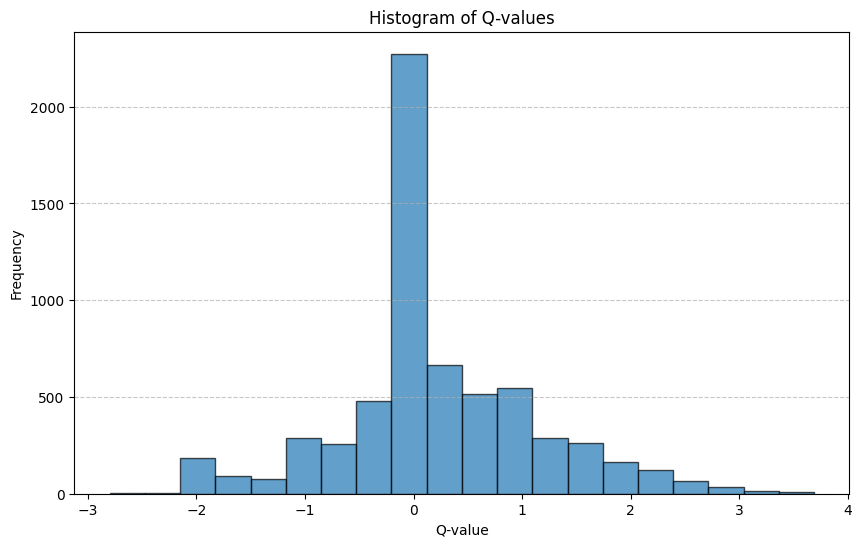

In [5]:
import matplotlib.pyplot as plt

q_matrix = Q.get()
print(f"Total unique states encountered: {len(q_matrix.keys())}")

# Extract all Q-values from the nested dictionary
all_q_values = [q - Q_initial_value  for actions in q_matrix.values() for q in actions.values()]
print(f"Total number of elements in Q: {len(all_q_values)}")

mean_q = np.mean(all_q_values)
median_q = np.median(all_q_values)
std_q = np.std(all_q_values)
min_q = np.min(all_q_values)
max_q = np.max(all_q_values)

print("Q-value Statistics:")
print(f"Mean: {mean_q}")
print(f"Median: {median_q}")
print(f"Standard Deviation: {std_q}")
print(f"Minimum: {min_q}")
print(f"Maximum: {max_q}")

plt.figure(figsize=(10, 6))
plt.hist(all_q_values, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Q-values")
plt.xlabel("Q-value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# with open('Q_optimal.pkl', 'wb') as f:
#     dill.dump(Q, f)

Statistics of visited state-action pairs:
Number of state-action pairs visited: 13537
Mean: 281.8284701189333
Median: 13.0
Standard Deviation: 2587.8806100429497
Minimum: 1
Maximum: 185950


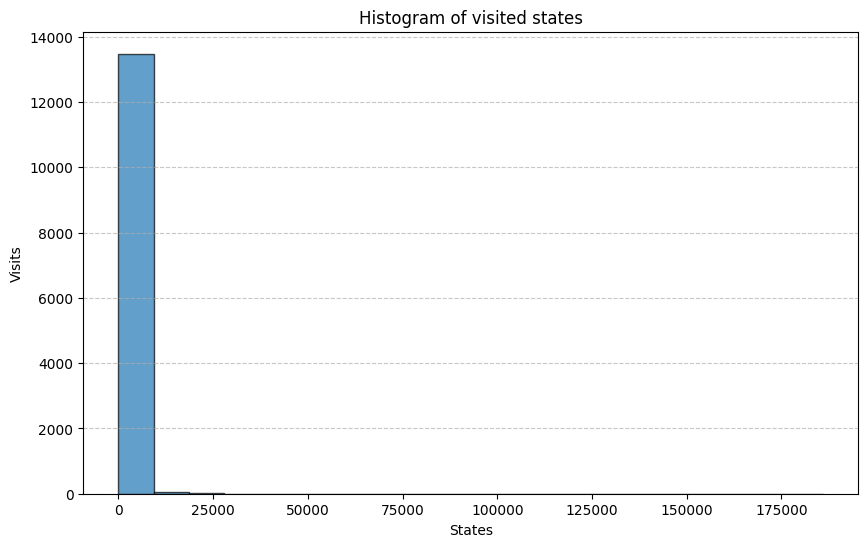

In [6]:
all_v = [v for states in Visits.values() for v in states.values()]

print("Statistics of visited state-action pairs:")
print(f"Number of state-action pairs visited: {len(all_v)}")

mean_v = np.mean(all_v)
median_v = np.median(all_v)
std_v = np.std(all_v)
min_v = np.min(all_v)
max_v = np.max(all_v)

print(f"Mean: {mean_v}")
print(f"Median: {median_v}")
print(f"Standard Deviation: {std_v}")
print(f"Minimum: {min_v}")
print(f"Maximum: {max_v}")

plt.figure(figsize=(10, 6))
plt.hist(all_v, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of visited states")
plt.ylabel("Visits")
plt.xlabel("States")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# Q = SymmetricQMatrix(default_value=1.0)

# board = [' ']*9
# print(board)
# action = 1
# new_value = 0.5
# print(Q.get(board, action))

# # Update a Q-value for a specific state-action pair
# Q.set(board, action, new_value)

# # Get the Q-value for a state-action pair
# print(Q.get(board, action))
# # Choose the best action for the current player
# best_action = Q.best_action(board, player='O')
# print(best_action)

In [8]:
# import random
# import time
# import dill

# import numpy as np
# from IPython.display import clear_output
# from collections import defaultdict

# # random.seed(42)  # Set the random seed

# # Parameters
# alpha = 0.1  # learning rate
# gamma = 0.9  # discount factor
# epsilon = 0.1  # exploration rate

# def defaultQ():
#     return 1.0  # Replace with your desired default value for actions

# def defaultVisits():
#     return 0  # Replace with your desired default value for actions

# # Initialize Q-matrix as a dictionary of dictionaries
# Q = defaultdict(lambda: defaultdict(defaultQ))
# Visits = defaultdict(lambda: defaultdict(defaultVisits))

# with open('Q_optimal.pkl', 'rb') as f:
#     Q_optimal = dill.load(f)

# # Initialize the Tic-Tac-Toe board
# def initialize_board():
#     return [' ' for _ in range(9)]

# # Display the board in a 3x3 format
# def display_board(board):
#     clear_output(wait=True)
#     print("\n")
#     print(f" {board[0]}  |  {board[1]}  |  {board[2]} ")
#     print("----+-----+----")
#     print(f" {board[3]}  |  {board[4]}  |  {board[5]} ")
#     print("----+-----+----")
#     print(f" {board[6]}  |  {board[7]}  |  {board[8]} ")
#     print("\n")

# # Display the board in a 3x3 format with Q-values on empty fields
# def display_board_with_Q(board, Q):
#     clear_output(wait=True)
#     state = get_state(board)
#     field = {i: board[i] if board[i] != ' ' else Q[state][i] - defaultQ() for i in range(9)}
#     def format_cell(value):
#         return f"{value:.1f}" if isinstance(value, (int, float)) else f" {value} "

#     print("\n")
#     print(f"{format_cell(field[0])} | {format_cell(field[1])} | {format_cell(field[2])}")
#     print("----+-----+----")
#     print(f"{format_cell(field[3])} | {format_cell(field[4])} | {format_cell(field[5])}")
#     print("----+-----+----")
#     print(f"{format_cell(field[6])} | {format_cell(field[7])} | {format_cell(field[8])}")
#     print("\n")

# # Check for a winning condition
# def check_winner(board, player):
#     win_conditions = [
#         [0, 1, 2], [3, 4, 5], [6, 7, 8],  # rows
#         [0, 3, 6], [1, 4, 7], [2, 5, 8],  # columns
#         [0, 4, 8], [2, 4, 6]              # diagonals
#     ]
#     for condition in win_conditions:
#         if all(board[pos] == player for pos in condition):
#             return True
#     return False

# # Check for a draw (no empty spaces)
# def check_draw(board):
#     return ' ' not in board

# # Convert a linear board to a 3x3 matrix for easier manipulation
# def to_matrix(board):
#     return np.array(board).reshape(3, 3)

# # Convert a 3x3 matrix back to a linear board representation
# def to_linear(matrix):
#     return matrix.flatten().tolist()

# # Generate all symmetrical transformations of a board
# def generate_symmetries(board):
#     matrix = to_matrix(board)
#     symmetries = [
#         matrix,                        # Original
#         np.rot90(matrix, 1),           # Rotate 90°
#         np.rot90(matrix, 2),           # Rotate 180°
#         np.rot90(matrix, 3),           # Rotate 270°
#         np.fliplr(matrix),             # Horizontal reflection
#         np.flipud(matrix),             # Vertical reflection
#         np.transpose(matrix),          # Diagonal reflection (TL-BR)
#         np.fliplr(np.transpose(matrix)) # Diagonal reflection (TR-BL)
#     ]
#     return [to_linear(sym) for sym in symmetries]

# def get_canonical_representation(board):
#     symmetries = generate_symmetries(board)
#     return min(symmetries)

# # State representation as a canonical tuple to be used as a dictionary key
# # Exploit symmetries to reduce the number of states
# def get_state(board):
#     canonical_representation = get_canonical_representation(board)
#     return tuple(canonical_representation)  # Convert to tuple for use as a dictionary key

# # State representation as a string
# # def get_state(board):
# #     return ''.join(board)  # Convert to string for use as a dictionary key

# # Update Q-values based on the game's outcome, with correct max_future_q
# def update_q_values(history, reward):
#     for i in range(len(history) - 1):
#         state, action = history[i]
#         next_state, _ = history[i + 1]
        
#         # Calculate max Q-value for the next state over all possible actions
#         max_future_q = max(Q[next_state].values(), default=0)
        
#         # Update Q-value for current state-action pair
#         Q[state][action] += alpha * (reward + gamma * max_future_q - Q[state][action])
#         # Update Visits
#         Visits[state][action] += 1
        
#     # Update the last state-action pair with the final reward
#     state, action = history[-1]
#     Q[state][action] += alpha * (reward - Q[state][action])
#     # Update Visits
#     Visits[state][action] += 1

# # Return optimal actions based on Q-values
# def get_best_actions(state, empty_positions, player, Q=Q):
#     # empty_positions = [i for i, cell in enumerate(board) if cell == ' ']
#     # state = get_state(board)
#     q_values = {pos: Q[state][pos] for pos in empty_positions}
#     if player == 'X':
#         max_q = max(q_values.values())
#         best_actions = [pos for pos, q in q_values.items() if q == max_q]
#     elif player == 'O':
#         min_q = min(q_values.values())
#         best_actions = [pos for pos, q in q_values.items() if q == min_q]
    
#     return best_actions

# # Choose an action based on Q-values
# def choose_action(state, empty_positions, player, epsilon=0.1):
#     if random.uniform(0, 1) < epsilon:
#         # Exploration: Choose a random move
#         return random.choice(empty_positions)
#     else:
#         # Exploitation: Choose the best known move
#         best_actions = get_best_actions(state, empty_positions, player)
#         return random.choice(best_actions)


# # Main game loop for two random agents
# def play_game(training=True, display=False):
#     board = initialize_board()
#     current_player = 'X'
#     history = []  # To store state-action pairs
#     total_actions = 0
#     optimal_actions = 0

#     while True:
#         empty_positions = [i for i, cell in enumerate(board) if cell == ' ']
#         state = get_state(board)
#         if empty_positions:
#             if training:
#                 action = choose_action(state, empty_positions, current_player, epsilon=epsilon)
#                 history.append((state, action))
#             else:
#                 action = choose_action(state, empty_positions, current_player, epsilon=0.0)

#             total_actions += 1
#             if action in get_best_actions(state, empty_positions, current_player, Q=Q_optimal):
#                 optimal_actions += 1

#             board[action] = current_player

#         if display:
#             display_board_with_Q(board, Q)
#             time.sleep(5)  # Wait a bit before the next move for readability
        
#         # Check for winner
#         if check_winner(board, current_player):
#             if display:
#                 display_board(board)
#                 print(f"Player {current_player} wins!\n")

#             if training:
#                 reward = 1 if current_player == 'X' else -1  # Reward for 'X', penalty for 'O'
#                 update_q_values(history, reward)
    
#             outcomes[current_player] += 1
#             break
        
#         # Check for draw
#         if check_draw(board):
#             if display:
#                 display_board(board)
#                 print("It's a draw!\n")

#             if training:
#                 reward = 0
#                 update_q_values(history, reward)

#             outcomes['D'] += 1
#             break
        
#         # Switch players
#         current_player = 'O' if current_player == 'X' else 'X'

#     ratio_of_optimal_actions.append(optimal_actions/total_actions)

# # Let the games begin
# nr_of_games = 5000
# ratio_of_optimal_actions = []
# outcomes = {'X' : 0, 'O' : 0, 'D' : 0}
# for _ in range(nr_of_games):
#     play_game(training=True)

# print("Outcomes with random action choices:")
# print(f"X wins: {outcomes['X']/nr_of_games}, O wins: {outcomes['O']/nr_of_games}, draws: {outcomes['D']/nr_of_games}")
# print(f"Ratio of optimal actions: {ratio_of_optimal_actions}")
# print(f"Ratio of optimal actions: {ratio_of_optimal_actions[-10:]}")